# Analysis Outline:
1. Data Exploration
2. Fitting a Neural Network Model suggested
3. Examining a methodology to optimize the model parameters and hyper parameters: Using Grid Search to optimize all the parameters at a same time
4. Examining orthogonalization methodoloy to optimize the model parameters and hyper parameters: Using Grid Search to optimize the important parameters separately in a sequence. As the next steps, ROC curve of the model was improved by adjusting the threshold.
5. Examining model performance using only important features


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

from keras import regularizers
from keras.models import Model, load_model
from keras.models import Sequential
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.optimizers import *
from keras.wrappers.scikit_learn import KerasClassifier
from keras.constraints import maxnorm

from scipy import stats
from scipy.stats import reciprocal
from pylab import rcParams
from __future__ import absolute_import, division, print_function


In [53]:
# fix random seed for reproducibility
np.random.seed(7)

In [79]:
# load pima indians dataset
col_names = ['pregnant', 'glucose', 'bp', 'skin', 'insulin', 'bmi', 'pedigree', 'age','label']
dataset = pd.read_csv("pima.csv", delimiter=",",header=None, names=col_names)

TEST_PCT = 0.2 # 20% of the data

#set up graphic style in this case I am using the color scheme from xkcd.com
rcParams['figure.figsize'] = 14, 8.7 # Golden Mean
LABELS = ["No diabetes","Diabetes"]
sns.set(style='white', font_scale=1.75)

label:
1: diabetes
0: no diabetes

pregnant:number of times pregnant

In [80]:
dataset.head()

,pregnant,glucose,bp,skin,insulin,bmi,pedigree,age,label
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [81]:
dataset.shape

(768, 9)

In [82]:
dataset.isnull().values.any()

False

In [84]:
pd.value_counts(dataset['label'], sort = True) #class count comparison 0=Not_pima 1=pima

0    500
1    268
Name: label, dtype: int64

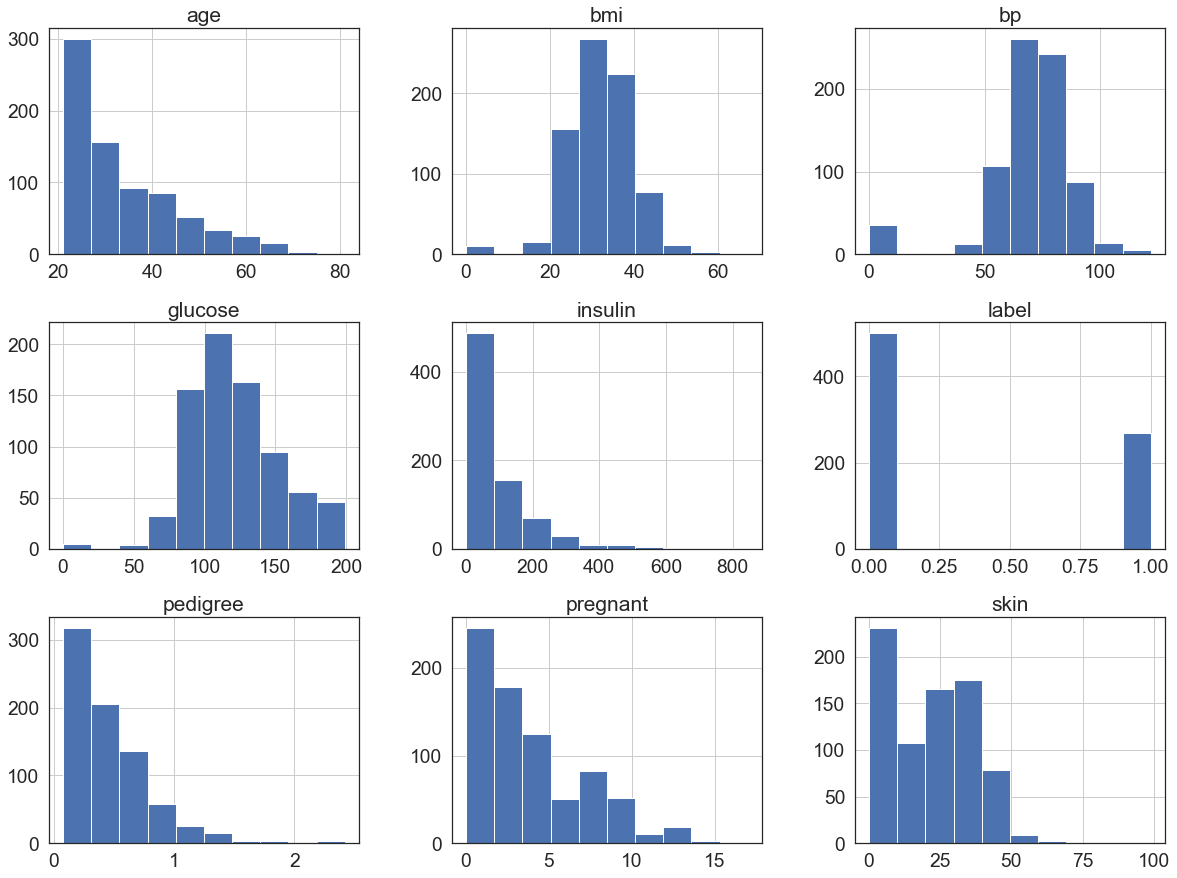

In [85]:
dataset.hist(figsize=(20,15))
plt.show()

In [87]:
dataset.dtypes

pregnant      int64
glucose       int64
bp            int64
skin          int64
insulin       int64
bmi         float64
pedigree    float64
age           int64
label         int64
dtype: object

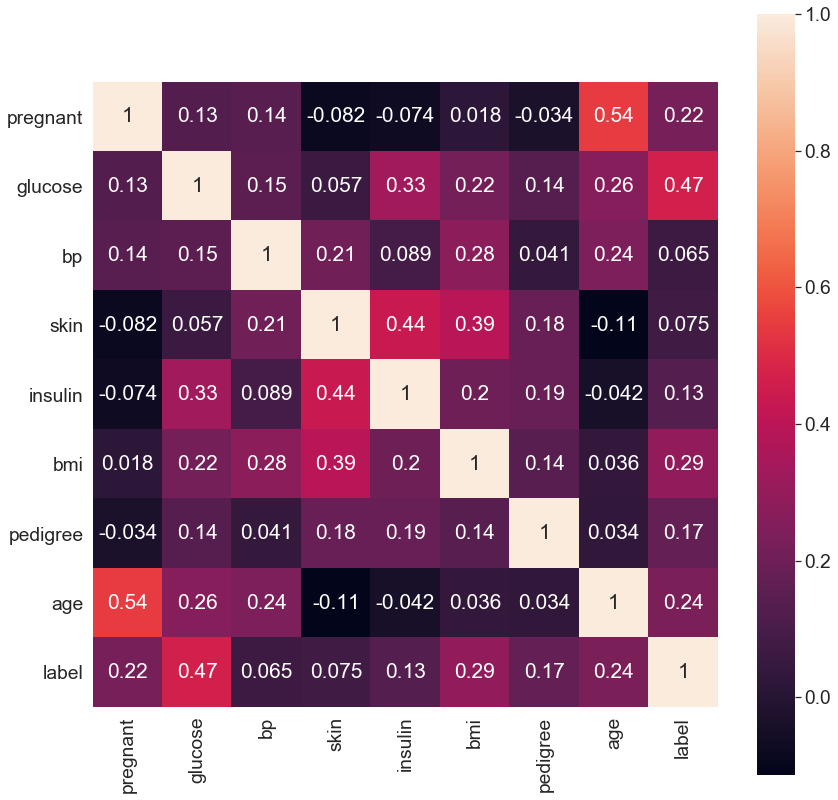

In [86]:
plt.figure(figsize=(14,14))
foo = sns.heatmap(dataset.corr(), vmax=1, square=True, annot=True)

Our output is more correlated with glocuse, and after that with bmi,age, and number of times person was pregnant, respectively.

In [157]:
# split into input (X) and output (Y) variables
X = dataset.iloc[:,0:8]
y = dataset.iloc[:,8]

In [158]:
# Standardize the data before modeling  
sc = StandardScaler()
sc.fit(X)
X_std = sc.transform(X)

In [159]:
#splitting train and test data
train_X, test_X, train_y, test_y = train_test_split(X_std,y,test_size=TEST_PCT , random_state=7)

In [160]:
#splitting train data into train and validation 
X_train, X_valid, y_train, y_valid = train_test_split(train_X,train_y,test_size=TEST_PCT , random_state=7)

In [14]:
# create model
model = Sequential()
model.add(Dense(12, input_dim=8, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [15]:
# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [16]:
# Fit the model
history=model.fit(X_train, y_train, epochs=150, batch_size=10,validation_data=(X_valid, y_valid))

Train on 491 samples, validate on 123 samples
Epoch 1/150
491/491 [==============================] - 0s 374us/step - loss: 0.6045 - accuracy: 0.6701 - val_loss: 0.6262 - val_accuracy: 0.6423
Epoch 2/150
491/491 [==============================] - 0s 126us/step - loss: 0.5637 - accuracy: 0.6965 - val_loss: 0.6033 - val_accuracy: 0.6748
Epoch 3/150
491/491 [==============================] - 0s 173us/step - loss: 0.5368 - accuracy: 0.7210 - val_loss: 0.5913 - val_accuracy: 0.6911
Epoch 4/150
491/491 [==============================] - 0s 130us/step - loss: 0.5166 - accuracy: 0.7230 - val_loss: 0.5805 - val_accuracy: 0.6911
Epoch 5/150
491/491 [==============================] - 0s 195us/step - loss: 0.5029 - accuracy: 0.7312 - val_loss: 0.5749 - val_accuracy: 0.6829
Epoch 6/150
491/491 [==============================] - 0s 124us/step - loss: 0.4909 - accuracy: 0.7495 - val_loss: 0.5710 - val_accuracy: 0.6992
Epoch 7/150
491/491 [==============================] - 0s 112us/step - loss: 0.4823 

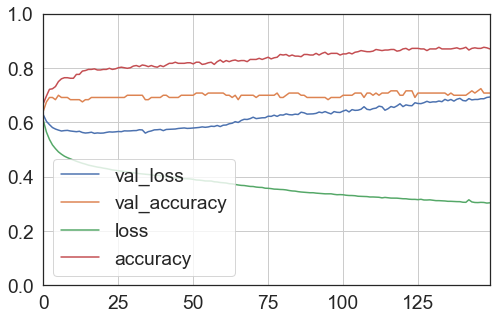

In [17]:
#Plot loss and accuracy of model for each epoch
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [18]:
#Evaluate model on test data
print('test loss, test acc:',model.evaluate(test_X,test_y,verbose=2))

test loss, test acc: [0.5047430968903875, 0.8051947951316833]


# Manual k-Fold Cross Validation

In [142]:
import numpy

In [186]:
#covert data to numpy array
X = np.asarray(X_std)
y = np.asarray(y)


In [27]:
#cross validation using Stratified K fold
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
cvscores = []
for train, test in kfold.split(X, y):
  # create model
    model = Sequential()
    model.add(Dense(12, input_dim=8, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    # Fit the model
    final=model.fit(X[train], y[train], epochs=150, batch_size=10, verbose=0)
    # evaluate the model
    scores = model.evaluate(X[test], y[test], verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)
print("%.2f%% (+/- %.2f%%)" % (numpy.mean(cvscores), numpy.std(cvscores)))

accuracy: 72.73%
accuracy: 71.43%
accuracy: 79.22%
accuracy: 77.92%
accuracy: 72.73%
accuracy: 70.13%
accuracy: 83.12%
accuracy: 75.32%
accuracy: 73.68%
accuracy: 76.32%
75.26% (+/- 3.77%)


# ROC curve and PR curve

In [34]:
test_X_predictions = model.predict(test_X)
mse = np.mean(np.power(test_X - test_X_predictions, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': test_y})
#error_df.describe()
error_df.True_class.value_counts()

0    97
1    57
Name: True_class, dtype: int64

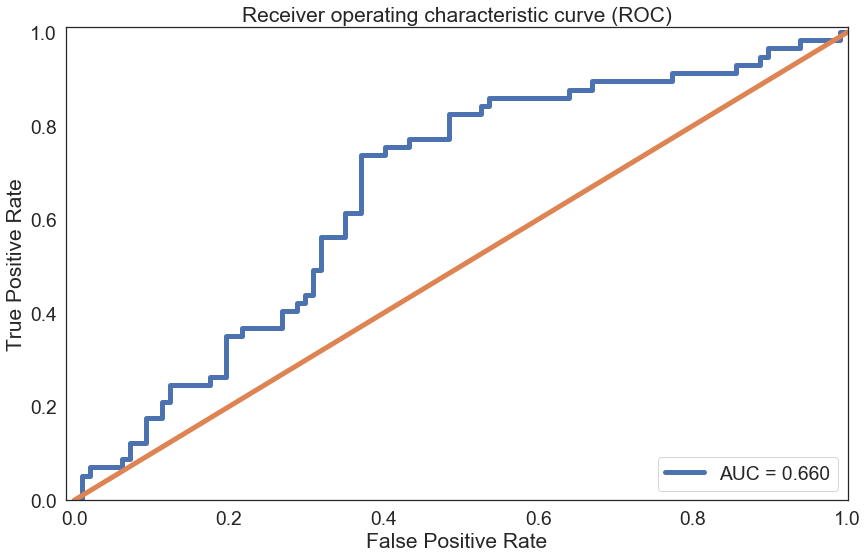

In [89]:
false_pos_rate, true_pos_rate, thresholds = roc_curve(error_df.True_class, error_df.Reconstruction_error)
roc_auc = auc(false_pos_rate, true_pos_rate,)

plt.plot(false_pos_rate, true_pos_rate, linewidth=5, label='AUC = %0.3f'% roc_auc)
plt.plot([0,1],[0,1], linewidth=5)

plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.legend(loc='lower right')
plt.title('Receiver operating characteristic curve (ROC)')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

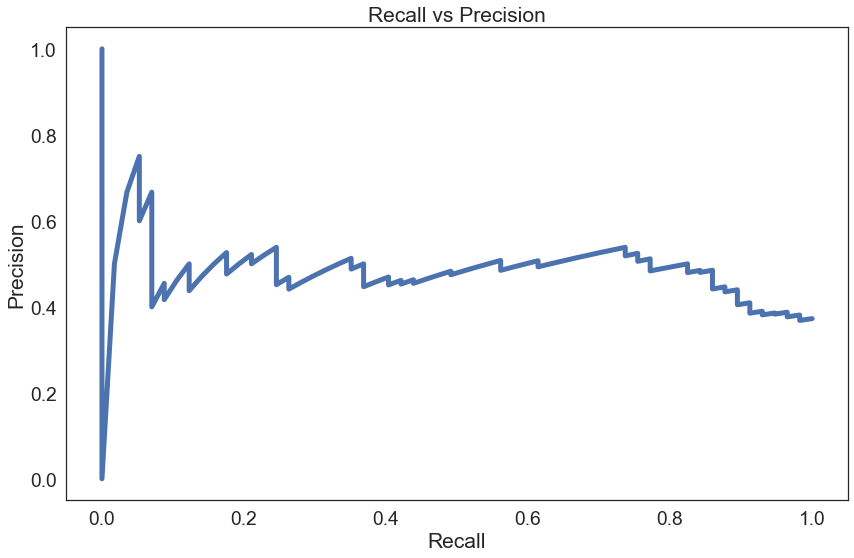

In [90]:

precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class, error_df.Reconstruction_error)
plt.plot(recall_rt, precision_rt, linewidth=5, label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

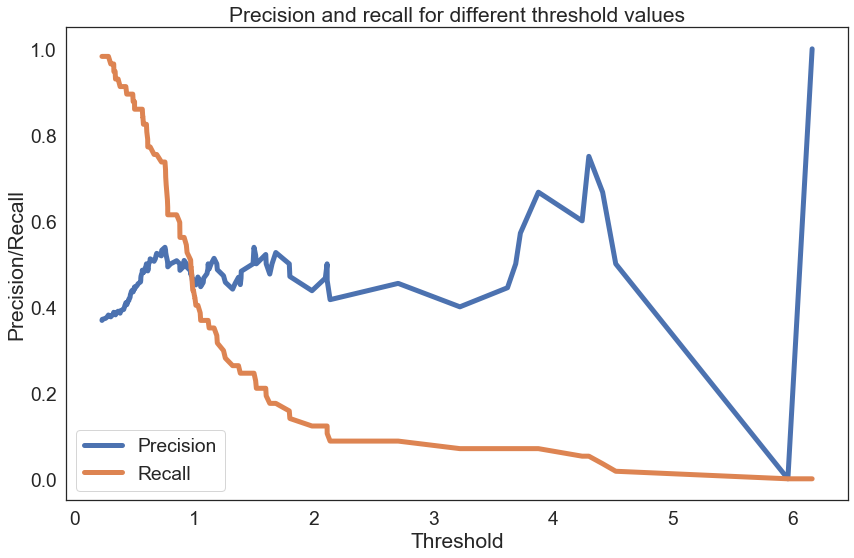

In [91]:
plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=5)
plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=5)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

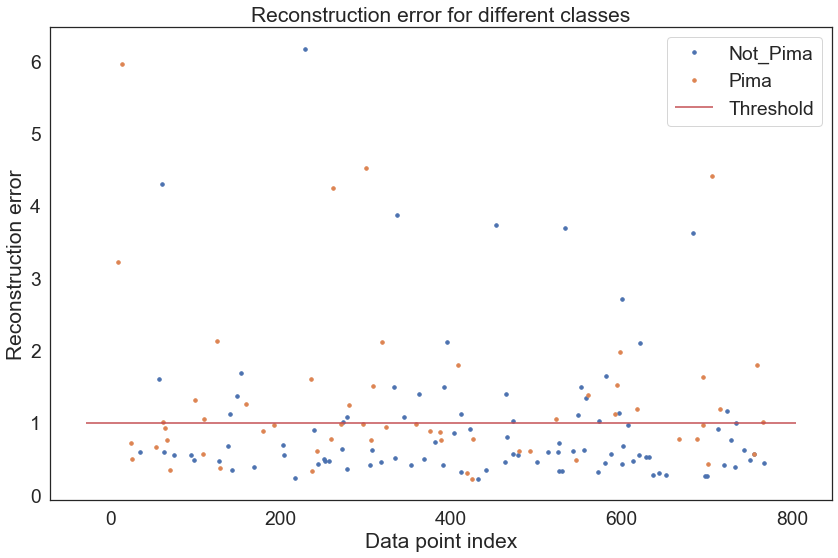

In [94]:
threshold_fixed = 1
groups = error_df.groupby('True_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Pima" if name == 1 else "Not_Pima")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

[[68 29]
 [32 25]]


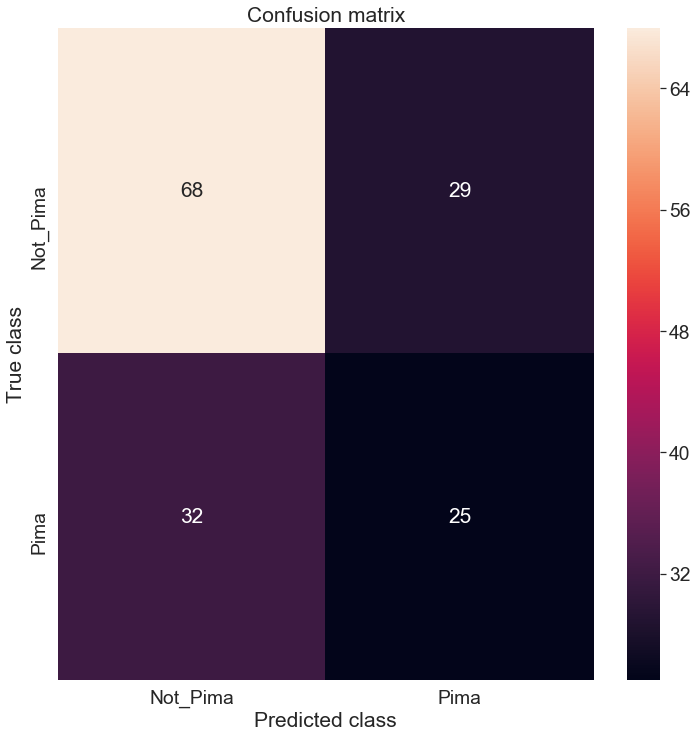

In [95]:
pred_y = [1 if e > threshold_fixed else 0 for e in error_df.Reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.True_class, pred_y)
print (conf_matrix)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

# Fine Tuning Model Hyper Parameters

In [284]:
def build_model(activation='relu',n_hidden=1, neurons=30, learning_rate=3e-3, input_shape=[8],optimizer='Adam'):
    model = keras.models.Sequential()
    options = {"input_shape": input_shape}
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(neurons, activation=activation, **options))
        options = {}
    model.add(keras.layers.Dense(1, **options,activation='sigmoid'))    
            
    model.compile(loss="binary_crossentropy",metrics = ['accuracy'], optimizer=optimizer)
    return model

In [285]:
from keras.models import Sequential

from keras.layers import Dense, Dropout

from keras.wrappers.scikit_learn import KerasClassifier



# Defining grid parameters

activation = ['elu', 'relu', 'tanh', 'sigmoid', 'selu']

neurons = [10, 20, 30, 40, 50]

optimizer = ['SGD', 'Adam', 'Adamax','AdaGrad','Nadam','RMSProp']
n_hidden = [1,2,3]
learning_rate =  [3e-4,3e-3, 3e-2]
param_grid = dict(activation = activation, neurons = neurons, optimizer = optimizer,n_hidden = n_hidden, learning_rate=learning_rate)



clf = KerasClassifier(build_fn= build_model, epochs= 50, batch_size=10, verbose= 0)



grid = GridSearchCV(estimator= clf, param_grid=param_grid, n_jobs=-1)

grid_result = grid.fit(train_X,train_y,workers=5)



# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.783388 using {'activation': 'selu', 'learning_rate': 0.03, 'n_hidden': 1, 'neurons': 20, 'optimizer': 'AdaGrad'}
0.760586 (0.013546) with: {'activation': 'elu', 'learning_rate': 0.0003, 'n_hidden': 1, 'neurons': 10, 'optimizer': 'SGD'}
0.771987 (0.021745) with: {'activation': 'elu', 'learning_rate': 0.0003, 'n_hidden': 1, 'neurons': 10, 'optimizer': 'Adam'}
0.763844 (0.008949) with: {'activation': 'elu', 'learning_rate': 0.0003, 'n_hidden': 1, 'neurons': 10, 'optimizer': 'Adamax'}
0.773616 (0.016251) with: {'activation': 'elu', 'learning_rate': 0.0003, 'n_hidden': 1, 'neurons': 10, 'optimizer': 'AdaGrad'}
0.760586 (0.013992) with: {'activation': 'elu', 'learning_rate': 0.0003, 'n_hidden': 1, 'neurons': 10, 'optimizer': 'Nadam'}
0.765472 (0.006375) with: {'activation': 'elu', 'learning_rate': 0.0003, 'n_hidden': 1, 'neurons': 10, 'optimizer': 'RMSProp'}
0.778502 (0.009986) with: {'activation': 'elu', 'learning_rate': 0.0003, 'n_hidden': 1, 'neurons': 20, 'optimizer': 'SGD'}
0.76

In [293]:
def create_model():
    # create model
    model = Sequential()
    model.add(Dense(20, input_dim=8, activation='selu'))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='AdaGrad', metrics=['accuracy'])
    return model

# create model
model = KerasClassifier(build_fn=create_model, verbose=0)
# define the grid search parameters
batch_size = [5,10, 20, 40]
epochs = [10, 50, 100, 150]
param_grid = dict(batch_size=batch_size, epochs=epochs)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(train_X, train_y, workers=3)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.781759 using {'batch_size': 40, 'epochs': 150}
0.763844 (0.006615) with: {'batch_size': 5, 'epochs': 10}
0.771987 (0.004365) with: {'batch_size': 5, 'epochs': 50}
0.770358 (0.004021) with: {'batch_size': 5, 'epochs': 100}
0.780130 (0.003561) with: {'batch_size': 5, 'epochs': 150}
0.771987 (0.008695) with: {'batch_size': 10, 'epochs': 10}
0.778502 (0.002094) with: {'batch_size': 10, 'epochs': 50}
0.776873 (0.001791) with: {'batch_size': 10, 'epochs': 100}
0.765472 (0.010384) with: {'batch_size': 10, 'epochs': 150}
0.773616 (0.011704) with: {'batch_size': 20, 'epochs': 10}
0.771987 (0.005604) with: {'batch_size': 20, 'epochs': 50}
0.770358 (0.014256) with: {'batch_size': 20, 'epochs': 100}
0.775244 (0.007538) with: {'batch_size': 20, 'epochs': 150}
0.758958 (0.009601) with: {'batch_size': 40, 'epochs': 10}
0.778502 (0.005718) with: {'batch_size': 40, 'epochs': 50}
0.768730 (0.009754) with: {'batch_size': 40, 'epochs': 100}
0.781759 (0.005625) with: {'batch_size': 40, 'epochs': 15

In [295]:
# Function to create model, required for KerasClassifier
def create_model(learn_rate=0.01):
    # create model
    model = Sequential()
    model.add(Dense(20, input_dim=8, activation='selu'))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    optimizer = Adagrad(lr=learn_rate)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

# create model
model = KerasClassifier(build_fn=create_model, epochs=150, batch_size=40, verbose=0)
# define the grid search parameters
learn_rate = [0.0003, 0.003, 0.03, 0.1]

param_grid = dict(learn_rate=learn_rate)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(train_X, train_y, workers=4)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

C:\Users\Taraneh\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best: 0.773616 using {'learn_rate': 0.003}
0.558632 (0.075465) with: {'learn_rate': 0.0003}
0.773616 (0.017563) with: {'learn_rate': 0.003}
0.765472 (0.020757) with: {'learn_rate': 0.03}
0.750814 (0.027701) with: {'learn_rate': 0.1}


In [296]:
# Use scikit-learn to grid search the weight initialization

# Function to create model, required for KerasClassifier
def create_model(init_mode='uniform'):
    # create model
    model = Sequential()
    model.add(Dense(20, input_dim=8, kernel_initializer=init_mode, activation='selu'))
    model.add(Dense(1, kernel_initializer=init_mode, activation='sigmoid'))
    # Compile model
    optimizer = Adagrad(lr=0.003)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

# create model
model = KerasClassifier(build_fn=create_model, epochs=150, batch_size=40, verbose=0)
# define the grid search parameters
init_mode = ['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']
param_grid = dict(init_mode=init_mode)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(train_X, train_y, workers=4)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.776873 using {'init_mode': 'normal'}
0.773616 (0.013588) with: {'init_mode': 'uniform'}
0.765472 (0.014000) with: {'init_mode': 'lecun_uniform'}
0.776873 (0.005614) with: {'init_mode': 'normal'}
0.656352 (0.009972) with: {'init_mode': 'zero'}
0.762215 (0.015699) with: {'init_mode': 'glorot_normal'}
0.771987 (0.008695) with: {'init_mode': 'glorot_uniform'}
0.758958 (0.011672) with: {'init_mode': 'he_normal'}
0.754072 (0.009983) with: {'init_mode': 'he_uniform'}


In [301]:
# Use scikit-learn to grid search the dropout rate

# Function to create model, required for KerasClassifier
def create_model(dropout_rate=0.0, weight_constraint=0):
    # create model
    model = Sequential()
    model.add(Dense(20, input_dim=8, kernel_initializer='normal', activation='selu', kernel_constraint=maxnorm(weight_constraint)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
    # Compile model
    optimizer = Adagrad(lr=0.003)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

# create model
model = KerasClassifier(build_fn=create_model, epochs=150, batch_size=40, verbose=0)
# define the grid search parameters
weight_constraint = [1, 2, 3, 4, 5]
dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
param_grid = dict(dropout_rate=dropout_rate, weight_constraint=weight_constraint)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(train_X, train_y)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.778502 using {'dropout_rate': 0.0, 'weight_constraint': 3}
0.765472 (0.010033) with: {'dropout_rate': 0.0, 'weight_constraint': 1}
0.768730 (0.011693) with: {'dropout_rate': 0.0, 'weight_constraint': 2}
0.778502 (0.007816) with: {'dropout_rate': 0.0, 'weight_constraint': 3}
0.775244 (0.006397) with: {'dropout_rate': 0.0, 'weight_constraint': 4}
0.776873 (0.005614) with: {'dropout_rate': 0.0, 'weight_constraint': 5}
0.770358 (0.011518) with: {'dropout_rate': 0.1, 'weight_constraint': 1}
0.770358 (0.007528) with: {'dropout_rate': 0.1, 'weight_constraint': 2}
0.776873 (0.005614) with: {'dropout_rate': 0.1, 'weight_constraint': 3}
0.773616 (0.005710) with: {'dropout_rate': 0.1, 'weight_constraint': 4}
0.768730 (0.009619) with: {'dropout_rate': 0.1, 'weight_constraint': 5}
0.770358 (0.015508) with: {'dropout_rate': 0.2, 'weight_constraint': 1}
0.775244 (0.010055) with: {'dropout_rate': 0.2, 'weight_constraint': 2}
0.770358 (0.011518) with: {'dropout_rate': 0.2, 'weight_constraint': 

In [304]:
#cross validation using Stratified K fold
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
cvscores = []
for train, test in kfold.split(X, y):
  # create model
    model = Sequential()
    model.add(Dense(20, input_dim=8, activation='selu',kernel_initializer='normal',kernel_constraint=maxnorm(3)))
    #model.add(Dense(8, activation='relu'))
    model.add(Dense(1, activation='sigmoid',kernel_initializer='normal'))
    # Compile model
    optimizer = Adagrad(lr=0.003)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    # Fit the model
    model.fit(X[train], y[train], epochs=150, batch_size=40, verbose=0)
    # evaluate the model
    scores = model.evaluate(X[test], y[test], verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)
print("%.2f%% (+/- %.2f%%)" % (numpy.mean(cvscores), numpy.std(cvscores)))

accuracy: 70.13%
accuracy: 80.52%
accuracy: 76.62%
accuracy: 79.22%
accuracy: 79.22%
accuracy: 72.73%
accuracy: 77.92%
accuracy: 74.03%
accuracy: 77.63%
accuracy: 77.63%
76.57% (+/- 3.11%)


In [305]:
test_X_predictions = model.predict(test_X)
mse = np.mean(np.power(test_X - test_X_predictions, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': test_y})
# error_df.describe()
error_df.True_class.value_counts()

0    97
1    57
Name: True_class, dtype: int64

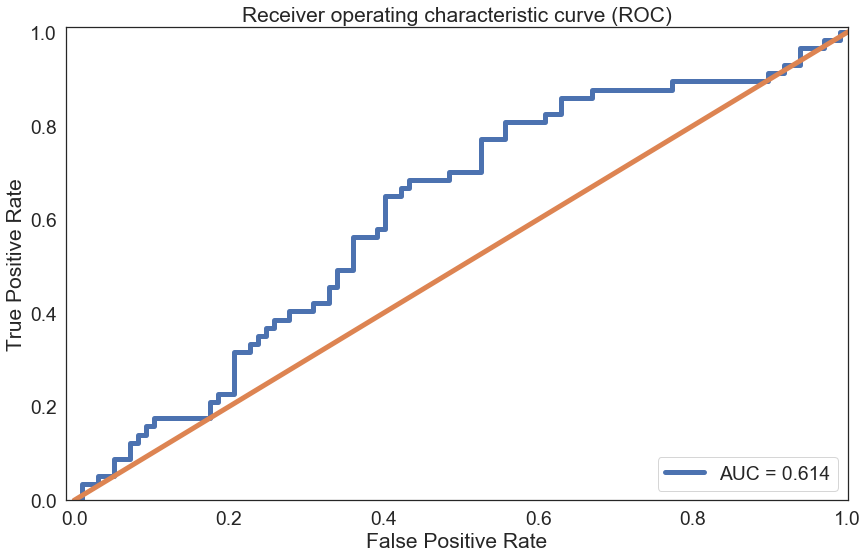

In [306]:
false_pos_rate, true_pos_rate, thresholds = roc_curve(error_df.True_class, error_df.Reconstruction_error)
roc_auc = auc(false_pos_rate, true_pos_rate,)

plt.plot(false_pos_rate, true_pos_rate, linewidth=5, label='AUC = %0.3f'% roc_auc)
plt.plot([0,1],[0,1], linewidth=5)

plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.legend(loc='lower right')
plt.title('Receiver operating characteristic curve (ROC)')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

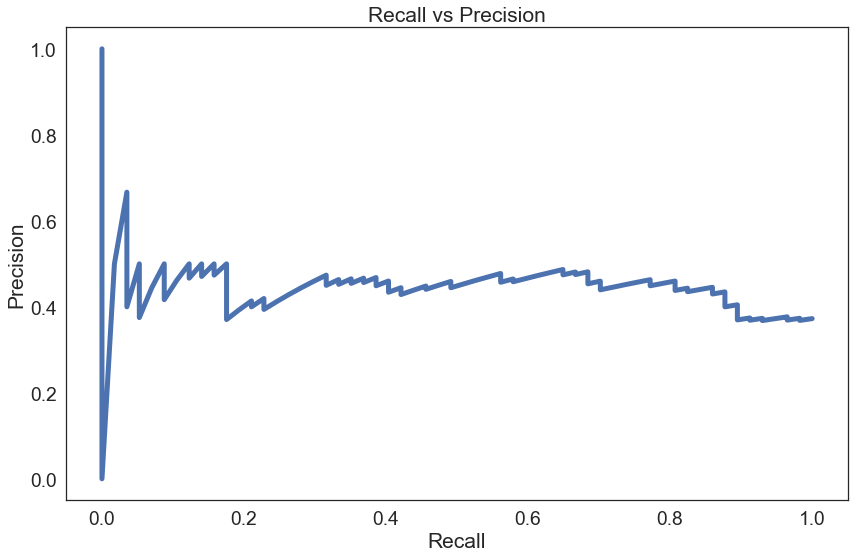

In [307]:
precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class, error_df.Reconstruction_error)
plt.plot(recall_rt, precision_rt, linewidth=5, label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

In [56]:
train_x = np.asarray(train_X) #transform to ndarray
train_y2 = np.asarray(train_y)

In [36]:

metrics=[tf.keras.metrics.AUC(),'accuracy']

#cross validation using Stratified K fold
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
cv_auc = []
cv_accuracy=[]
for train, test in kfold.split(X,y):
  # create model
    model = Sequential()
    model.add(Dense(20, input_dim=8, activation='selu',kernel_initializer='normal',kernel_constraint=maxnorm(3)))
    #model.add(Dense(8, activation='relu'))
    model.add(Dense(1, activation='sigmoid',kernel_initializer='normal'))
    # Compile model
    optimizer = Adagrad(lr=0.003)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=metrics)
    # Fit the model
    model.fit(X[train], y[train], epochs=150, batch_size=40, verbose=0)
    # evaluate the model
    scores = model.evaluate(X[test], y[test], verbose=0)
    print(model.metrics_names[1], scores[1], model.metrics_names[2], scores[2]*100)
    cv_auc.append(scores[1])
    cv_accuracy.append(scores[2]*100)
print(numpy.mean(cv_auc), numpy.std(cv_auc), "%.2f%% (+/- %.2f%%)" % (numpy.mean(cv_accuracy), numpy.std(cv_accuracy)))

auc_1 0.8204228281974792 accuracy 76.6233742237091
auc_1 0.8248271346092224 accuracy 76.6233742237091
auc_1 0.8233230710029602 accuracy 77.92207598686218
auc_1 0.8225924968719482 accuracy 81.81818127632141
auc_1 0.8242282271385193 accuracy 75.32467246055603
auc_1 0.8246519565582275 accuracy 71.42857313156128
auc_1 0.8235942721366882 accuracy 81.81818127632141
auc_1 0.8233140110969543 accuracy 77.92207598686218
auc_1 0.823432445526123 accuracy 77.63158082962036
auc_1 0.8231614232063293 accuracy 80.26315569877625
0.8233547866344452 0.0011787393601881983 77.74% (+/- 2.96%)


In [38]:
model = Sequential()
model.add(Dense(20, input_dim=8, activation='selu',kernel_initializer='normal',kernel_constraint=maxnorm(3)))
model.add(Dense(1, activation='sigmoid',kernel_initializer='normal'))
# Compile model
optimizer = Adagrad(lr=0.003)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=metrics)
# Fit the model
history=model.fit(X_train, y_train, epochs=150, batch_size=40,validation_data=(X_valid, y_valid))

Train on 491 samples, validate on 123 samples
Epoch 1/150
491/491 [==============================] - 0s 362us/step - loss: 0.6872 - auc_1: 0.8223 - accuracy: 0.6008 - val_loss: 0.6788 - val_auc_1: 0.8222 - val_accuracy: 0.6260
Epoch 2/150
491/491 [==============================] - 0s 57us/step - loss: 0.6688 - auc_1: 0.8222 - accuracy: 0.7128 - val_loss: 0.6664 - val_auc_1: 0.8221 - val_accuracy: 0.6423
Epoch 3/150
491/491 [==============================] - 0s 49us/step - loss: 0.6545 - auc_1: 0.8221 - accuracy: 0.7291 - val_loss: 0.6557 - val_auc_1: 0.8221 - val_accuracy: 0.6423
Epoch 4/150
491/491 [==============================] - 0s 51us/step - loss: 0.6417 - auc_1: 0.8220 - accuracy: 0.7454 - val_loss: 0.6465 - val_auc_1: 0.8220 - val_accuracy: 0.6585
Epoch 5/150
491/491 [==============================] - 0s 69us/step - loss: 0.6307 - auc_1: 0.8219 - accuracy: 0.7536 - val_loss: 0.6383 - val_auc_1: 0.8219 - val_accuracy: 0.6667
Epoch 6/150
491/491 [==============================] 

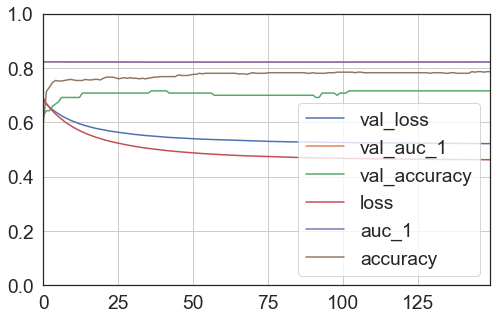

In [39]:
#Plot loss and accuracy of model for each epoch
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [40]:
test_X_predictions = model.predict(test_X)
mse = np.mean(np.power(test_X - test_X_predictions, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': test_y})
# error_df.describe()
error_df.True_class.value_counts()

0    97
1    57
Name: True_class, dtype: int64

In [41]:
error_df

,Reconstruction_error,True_class
353,0.497670,0
236,0.322776,1
323,0.933136,1
98,0.542499,0
701,0.397347,1
...,...,...
153,1.694631,0
392,1.521584,0
308,1.313862,1
70,0.377069,1


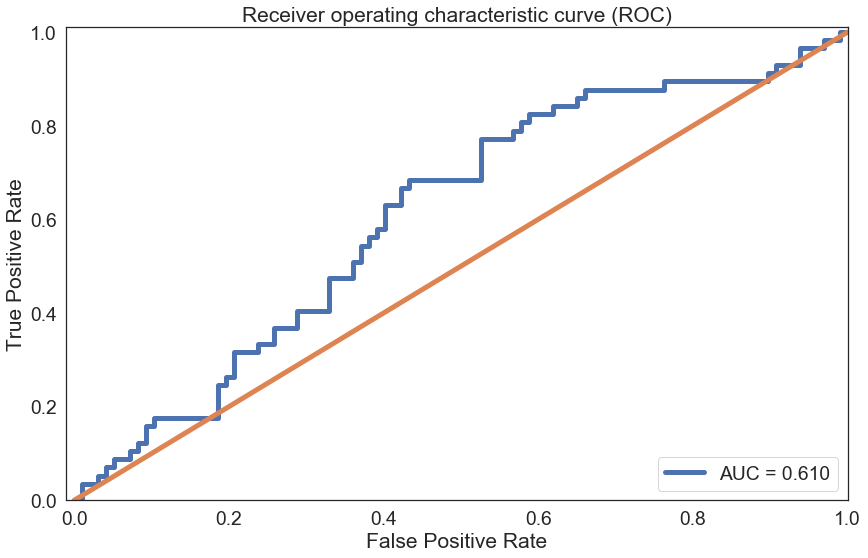

In [42]:

false_pos_rate, true_pos_rate, thresholds = roc_curve(error_df.True_class, error_df.Reconstruction_error)
roc_auc = auc(false_pos_rate, true_pos_rate,)

plt.plot(false_pos_rate, true_pos_rate, linewidth=5, label='AUC = %0.3f'% roc_auc)
plt.plot([0,1],[0,1], linewidth=5)

plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.legend(loc='lower right')
plt.title('Receiver operating characteristic curve (ROC)')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

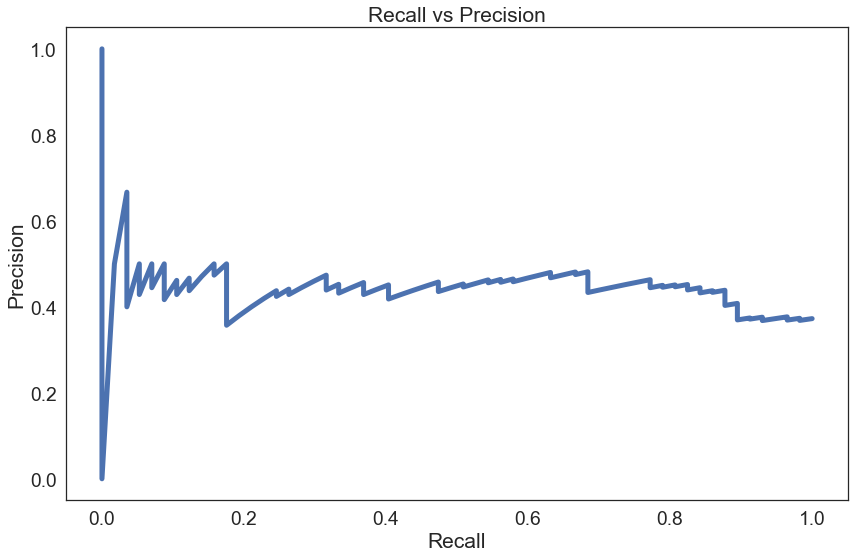

In [43]:
precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class, error_df.Reconstruction_error)
plt.plot(recall_rt, precision_rt, linewidth=5, label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

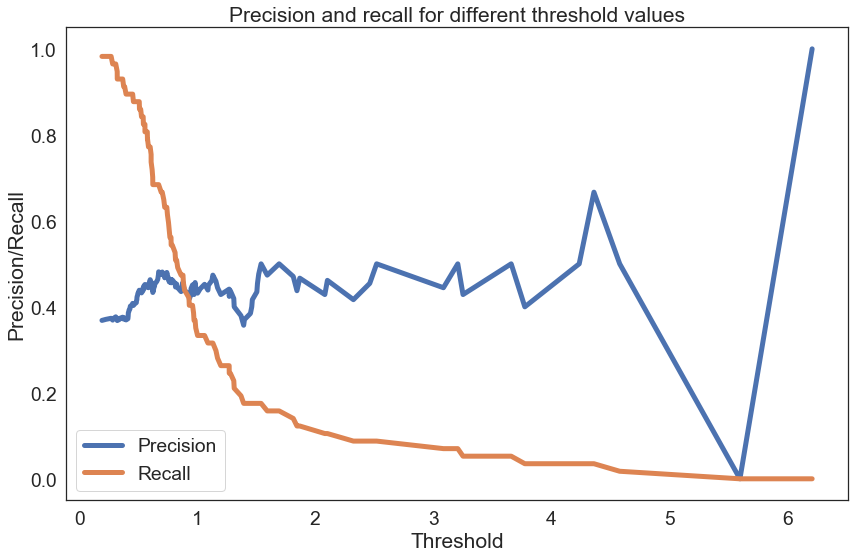

In [44]:
plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=5)
plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=5)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

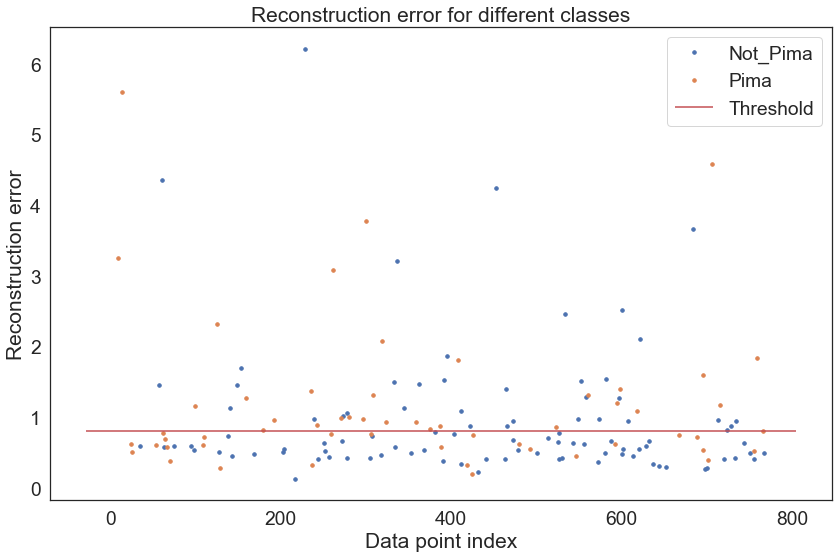

In [49]:
threshold_fixed = 0.8
groups = error_df.groupby('True_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Pima" if name == 1 else "Not_Pima")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

[[61 36]
 [26 31]]


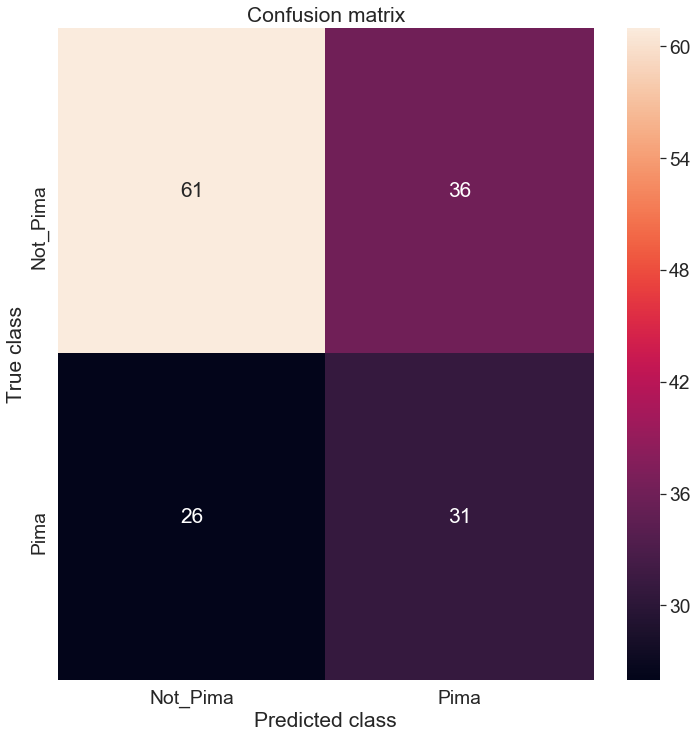

In [50]:
pred_y = [1 if e > threshold_fixed else 0 for e in error_df.Reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.True_class, pred_y)
print (conf_matrix)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [70]:
# create model
model = Sequential()
model.add(Dense(20, input_dim=8, activation='selu',kernel_initializer='normal',kernel_constraint=maxnorm(3)))
#model.add(Dense(8, activation='relu'))

model.add(Dense(1, activation='sigmoid'))

In [71]:
# Compile model
metrics=[tf.keras.metrics.AUC(),'accuracy']
optimizer=Adagrad(lr=0.003)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=metrics)

In [72]:
# Fit the model
history=model.fit(X_train, y_train, epochs=150, batch_size=40,validation_data=(X_valid, y_valid))

Train on 491 samples, validate on 123 samples
Epoch 1/150
491/491 [==============================] - 0s 828us/step - loss: 0.6685 - auc_16: 0.5401 - accuracy: 0.5703 - val_loss: 0.6478 - val_auc_16: 0.6276 - val_accuracy: 0.6341
Epoch 2/150
491/491 [==============================] - 0s 83us/step - loss: 0.6185 - auc_16: 0.6648 - accuracy: 0.6945 - val_loss: 0.6208 - val_auc_16: 0.6865 - val_accuracy: 0.6748
Epoch 3/150
491/491 [==============================] - 0s 77us/step - loss: 0.5934 - auc_16: 0.7076 - accuracy: 0.7108 - val_loss: 0.6026 - val_auc_16: 0.7164 - val_accuracy: 0.6911
Epoch 4/150
491/491 [==============================] - 0s 90us/step - loss: 0.5753 - auc_16: 0.7263 - accuracy: 0.7189 - val_loss: 0.5903 - val_auc_16: 0.7355 - val_accuracy: 0.6992
Epoch 5/150
491/491 [==============================] - 0s 114us/step - loss: 0.5626 - auc_16: 0.7436 - accuracy: 0.7312 - val_loss: 0.5803 - val_auc_16: 0.7480 - val_accuracy: 0.7154
Epoch 6/150
491/491 [=====================

In [73]:
test_X_predictions = model.predict(test_X)
mse = np.mean(np.power(test_X - test_X_predictions, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': test_y})
# error_df.describe()
error_df.True_class.value_counts()

0    97
1    57
Name: True_class, dtype: int64

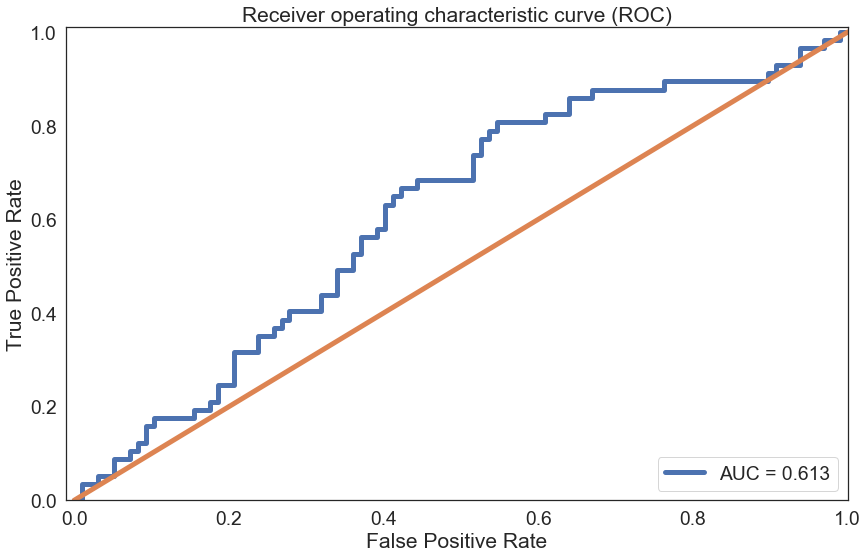

In [74]:
false_pos_rate, true_pos_rate, thresholds = roc_curve(error_df.True_class, error_df.Reconstruction_error)
roc_auc = auc(false_pos_rate, true_pos_rate,)

plt.plot(false_pos_rate, true_pos_rate, linewidth=5, label='AUC = %0.3f'% roc_auc)
plt.plot([0,1],[0,1], linewidth=5)

plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.legend(loc='lower right')
plt.title('Receiver operating characteristic curve (ROC)')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

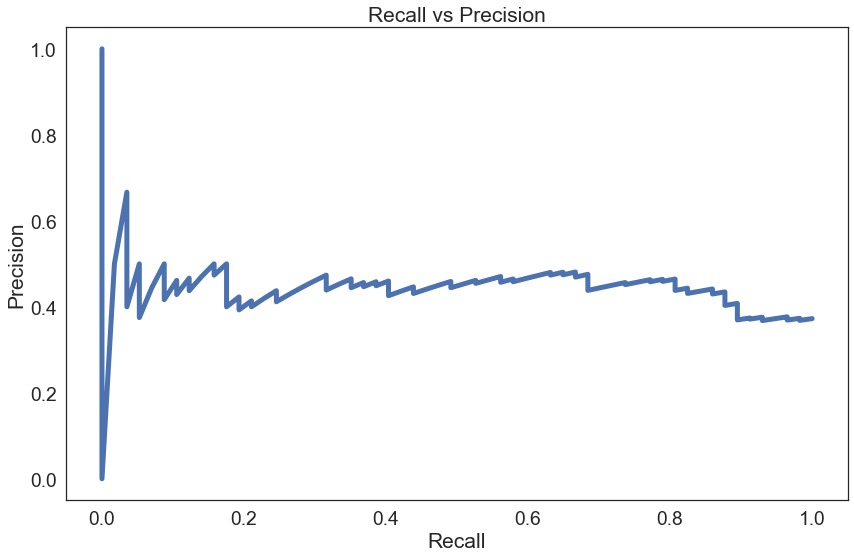

In [75]:
precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class, error_df.Reconstruction_error)
plt.plot(recall_rt, precision_rt, linewidth=5, label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

# 4. Examining orthogonalization methodoloy to optimize the model parameters and hyper parameters one by one

In [174]:
# Finding the best optimizer
def create_model(optimizer='Adam'):
    # create model
    model = Sequential()
    model.add(Dense(12, input_dim=8, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

# create model
model = KerasClassifier(build_fn=create_model, verbose=0)

# define the grid search parameters
optimizer = ['SGD', 'Adam', 'Adamax','AdaGrad','Nadam','RMSProp']
param_grid = dict(optimizer=optimizer)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=10)
grid_result = grid.fit(train_X, train_y, workers=3)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.700238 using {'optimizer': 'AdaGrad'}
0.550873 (0.140935) with: {'optimizer': 'SGD'}
0.577737 (0.099963) with: {'optimizer': 'Adam'}
0.509889 (0.138178) with: {'optimizer': 'Adamax'}
0.700238 (0.081282) with: {'optimizer': 'AdaGrad'}
0.589741 (0.116510) with: {'optimizer': 'Nadam'}
0.621946 (0.066128) with: {'optimizer': 'RMSProp'}


Based on Keras documentation, Adagrad is an optimizer with parameter-specific learning rates, which are adapted relative to how frequently a parameter gets updated during training. The more updates a parameter receives, the smaller the learning rate.
It is recommended to leave the parameters of this optimizer at their default values.

In [176]:
# Finding the best number of neurons for each layer
def create_model(n_neurons_1=12, n_neurons_2=8 ):
    # create model
    model = Sequential()
    model.add(Dense(n_neurons_1, input_dim=8, activation='relu'))
    model.add(Dense(n_neurons_2, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='Adagrad', metrics=['accuracy'])
    return model

# create model
model = KerasClassifier(build_fn=create_model, verbose=0)

# define the grid search parameters
n_neurons_1=[8,12,13,14,15,16,18]
n_neurons_2=[8,7,6,5,4]
param_grid = dict(n_neurons_1=n_neurons_1, n_neurons_2=n_neurons_2)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=10)
grid_result = grid.fit(train_X, train_y, workers=3)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.713247 using {'n_neurons_1': 16, 'n_neurons_2': 8}
0.685510 (0.050494) with: {'n_neurons_1': 8, 'n_neurons_2': 8}
0.659625 (0.041475) with: {'n_neurons_1': 8, 'n_neurons_2': 7}
0.672422 (0.047172) with: {'n_neurons_1': 8, 'n_neurons_2': 6}
0.618720 (0.120923) with: {'n_neurons_1': 8, 'n_neurons_2': 5}
0.616605 (0.112483) with: {'n_neurons_1': 8, 'n_neurons_2': 4}
0.645056 (0.071443) with: {'n_neurons_1': 12, 'n_neurons_2': 8}
0.672766 (0.056483) with: {'n_neurons_1': 12, 'n_neurons_2': 7}
0.656504 (0.116196) with: {'n_neurons_1': 12, 'n_neurons_2': 6}
0.680592 (0.082252) with: {'n_neurons_1': 12, 'n_neurons_2': 5}
0.631994 (0.068445) with: {'n_neurons_1': 12, 'n_neurons_2': 4}
0.688815 (0.052834) with: {'n_neurons_1': 13, 'n_neurons_2': 8}
0.697039 (0.060165) with: {'n_neurons_1': 13, 'n_neurons_2': 7}
0.633633 (0.117258) with: {'n_neurons_1': 13, 'n_neurons_2': 6}
0.673057 (0.113806) with: {'n_neurons_1': 13, 'n_neurons_2': 5}
0.661079 (0.098164) with: {'n_neurons_1': 13, 'n_n

In [177]:
# Finding the best mini batch size and number of epochs
def create_model():
    # create model
    model = Sequential()
    model.add(Dense(16, input_dim=8, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='AdaGrad', metrics=['accuracy'])
    return model

# create model
model = KerasClassifier(build_fn=create_model, verbose=0)

# define the grid search parameters
batch_size = [32,64,128,256,512]
epochs = [10, 50, 100, 150]
param_grid = dict(batch_size=batch_size, epochs=epochs)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=10)
grid_result = grid.fit(train_X, train_y, workers=3)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.765468 using {'batch_size': 64, 'epochs': 100}
0.739424 (0.067916) with: {'batch_size': 32, 'epochs': 10}
0.760418 (0.069094) with: {'batch_size': 32, 'epochs': 50}
0.765336 (0.071205) with: {'batch_size': 32, 'epochs': 100}
0.755658 (0.068029) with: {'batch_size': 32, 'epochs': 150}
0.757298 (0.054883) with: {'batch_size': 64, 'epochs': 10}
0.752459 (0.073143) with: {'batch_size': 64, 'epochs': 50}
0.765468 (0.068334) with: {'batch_size': 64, 'epochs': 100}
0.749233 (0.055407) with: {'batch_size': 64, 'epochs': 150}
0.726256 (0.053633) with: {'batch_size': 128, 'epochs': 10}
0.765362 (0.081373) with: {'batch_size': 128, 'epochs': 50}
0.749127 (0.078163) with: {'batch_size': 128, 'epochs': 100}
0.757271 (0.075416) with: {'batch_size': 128, 'epochs': 150}
0.729508 (0.071071) with: {'batch_size': 256, 'epochs': 10}
0.754045 (0.073153) with: {'batch_size': 256, 'epochs': 50}
0.755605 (0.076214) with: {'batch_size': 256, 'epochs': 100}
0.755632 (0.070888) with: {'batch_size': 256, 

In [178]:
#Finding the best activation function
def create_model(activation='relu'):
    # create model
    model = Sequential()
    model.add(Dense(16, input_dim=8, activation=activation))
    model.add(Dense(8, activation=activation))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='AdaGrad', metrics=['accuracy'])
    return model

# create model
model = KerasClassifier(build_fn=create_model, epochs=100, batch_size=64, verbose=0)

# define the grid search parameters
activation = ['elu', 'relu', 'tanh', 'sigmoid', 'selu']
param_grid = dict(activation=activation)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=10)
grid_result = grid.fit(train_X, train_y, workers=3)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))




Best: 0.780090 using {'activation': 'selu'}
0.760550 (0.068536) with: {'activation': 'elu'}
0.766922 (0.066771) with: {'activation': 'relu'}
0.762136 (0.075263) with: {'activation': 'tanh'}
0.763855 (0.058876) with: {'activation': 'sigmoid'}
0.780090 (0.050463) with: {'activation': 'selu'}


In [180]:
# Finding the best weight initialization
def create_model(init_mode='uniform'):
    # create model
    model = Sequential()
    model.add(Dense(16, input_dim=8, activation='selu'))
    model.add(Dense(8, activation='selu'))
    model.add(Dense(1, kernel_initializer=init_mode, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='AdaGrad', metrics=['accuracy'])
    return model

# create model
model = KerasClassifier(build_fn=create_model, epochs=100, batch_size=64, verbose=0)

# define the grid search parameters
init_mode = ['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']
param_grid = dict(init_mode=init_mode)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=10)
grid_result = grid.fit(train_X, train_y, workers=3)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))


Best: 0.768720 using {'init_mode': 'normal'}
0.763829 (0.070879) with: {'init_mode': 'uniform'}
0.762136 (0.065296) with: {'init_mode': 'lecun_uniform'}
0.768720 (0.068309) with: {'init_mode': 'normal'}
0.767081 (0.076991) with: {'init_mode': 'zero'}
0.762216 (0.069459) with: {'init_mode': 'glorot_normal'}
0.757245 (0.073788) with: {'init_mode': 'glorot_uniform'}
0.762163 (0.066348) with: {'init_mode': 'he_normal'}
0.762189 (0.083549) with: {'init_mode': 'he_uniform'}


Based on the values above, we can see that initializers do not have much affect on our model. So I will leave them to default value of 'glorot_uniform'.

In [182]:
# Finding the best Regularizer (l2 regulazition method)
def create_model(regularizer=0.01):
    # create model
    model = Sequential()
    model.add(Dense(16, input_dim=8, kernel_regularizer=regularizers.l2(regularizer), activation='selu'))
    model.add(Dense(8, activation='selu'))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='AdaGrad', metrics=['accuracy'])
    return model

# create model
model = KerasClassifier(build_fn=create_model, epochs=100, batch_size=64, verbose=0)

# define the grid search parameters
regularizer=[0.01,0.03,0.05,0.07,0.09,0.1,]
param_grid = dict(regularizer=regularizer)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=10)
grid_result = grid.fit(train_X, train_y, workers=3)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.776811 using {'regularizer': 0.09}
0.768667 (0.061306) with: {'regularizer': 0.01}
0.770307 (0.062766) with: {'regularizer': 0.03}
0.770280 (0.072668) with: {'regularizer': 0.05}
0.770360 (0.069781) with: {'regularizer': 0.07}
0.776811 (0.062693) with: {'regularizer': 0.09}
0.776785 (0.058747) with: {'regularizer': 0.1}


In [184]:
# Finding the best Dropout rate for regularization
def create_model(dropout_rate_1=0.0,dropout_rate_2=0.0):
    # create model
    model = Sequential()
    model.add(Dense(16, input_dim=8, activation='selu'))
    model.add(Dropout(dropout_rate_1))
    model.add(Dense(8, activation='selu'))
    model.add(Dropout(dropout_rate_2))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='AdaGrad', metrics=['accuracy'])
    return model

# create model
model = KerasClassifier(build_fn=create_model, epochs=100, batch_size=64, verbose=0)

# define the grid search parameters
dropout_rate_1 = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
dropout_rate_2 = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
param_grid = dict(dropout_rate_1=dropout_rate_1, dropout_rate_2=dropout_rate_2)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=10)
grid_result = grid.fit(train_X, train_y, workers=3)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.781650 using {'dropout_rate_1': 0.2, 'dropout_rate_2': 0.8}
0.754072 (0.082772) with: {'dropout_rate_1': 0.0, 'dropout_rate_2': 0.0}
0.765415 (0.073225) with: {'dropout_rate_1': 0.0, 'dropout_rate_2': 0.1}
0.765415 (0.074272) with: {'dropout_rate_1': 0.0, 'dropout_rate_2': 0.2}
0.763776 (0.069599) with: {'dropout_rate_1': 0.0, 'dropout_rate_2': 0.3}
0.778424 (0.073048) with: {'dropout_rate_1': 0.0, 'dropout_rate_2': 0.4}
0.770227 (0.061821) with: {'dropout_rate_1': 0.0, 'dropout_rate_2': 0.5}
0.776785 (0.068071) with: {'dropout_rate_1': 0.0, 'dropout_rate_2': 0.6}
0.771920 (0.058293) with: {'dropout_rate_1': 0.0, 'dropout_rate_2': 0.7}
0.762242 (0.067472) with: {'dropout_rate_1': 0.0, 'dropout_rate_2': 0.8}
0.755605 (0.060915) with: {'dropout_rate_1': 0.0, 'dropout_rate_2': 0.9}
0.768641 (0.067245) with: {'dropout_rate_1': 0.1, 'dropout_rate_2': 0.0}
0.767028 (0.070348) with: {'dropout_rate_1': 0.1, 'dropout_rate_2': 0.1}
0.762136 (0.063709) with: {'dropout_rate_1': 0.1, 'dropo

Adding l2 regularizer and Dropout are common regularization methods. Based on the optimum results for these 2 methods, I chose l2 regularizer since the results are more consistant and having a high dropout rate for the last layer is not recommended. 

## Cross-validating the model with optimum parameters and hyperparameters

In [187]:
#cross validation using Stratified K fold
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
cvscores = []
for train, test in kfold.split(X, y):
  # create model
    model = Sequential()
    model.add(Dense(16, input_dim=8, kernel_regularizer=regularizers.l2(0.09), activation='selu'))
    model.add(Dense(8, activation='selu'))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='AdaGrad', metrics=['accuracy'])
    
    # Fit the model
    final=model.fit(X[train], y[train], epochs=100, batch_size=64, verbose=0)
    # evaluate the model
    scores = model.evaluate(X[test], y[test], verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)
print("%.2f%% (+/- %.2f%%)" % (numpy.mean(cvscores), numpy.std(cvscores)))

accuracy: 75.32%
accuracy: 77.92%
accuracy: 77.92%
accuracy: 80.52%
accuracy: 74.03%
accuracy: 71.43%
accuracy: 84.42%
accuracy: 75.32%
accuracy: 77.63%
accuracy: 80.26%
77.48% (+/- 3.51%)


## Evaluating ROC curve of model

In [188]:
test_X_predictions = model.predict(test_X)
mse = np.mean(np.power(test_X - test_X_predictions, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': test_y})
# error_df.describe()
error_df.True_class.value_counts()

0    97
1    57
Name: True_class, dtype: int64

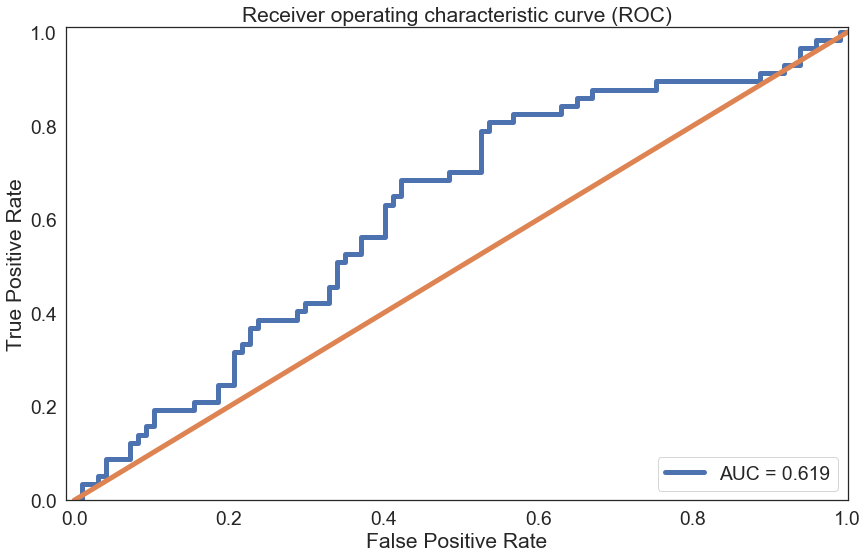

In [189]:
false_pos_rate, true_pos_rate, thresholds = roc_curve(error_df.True_class, error_df.Reconstruction_error)
roc_auc = auc(false_pos_rate, true_pos_rate,)

plt.plot(false_pos_rate, true_pos_rate, linewidth=5, label='AUC = %0.3f'% roc_auc)
plt.plot([0,1],[0,1], linewidth=5)

plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.legend(loc='lower right')
plt.title('Receiver operating characteristic curve (ROC)')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

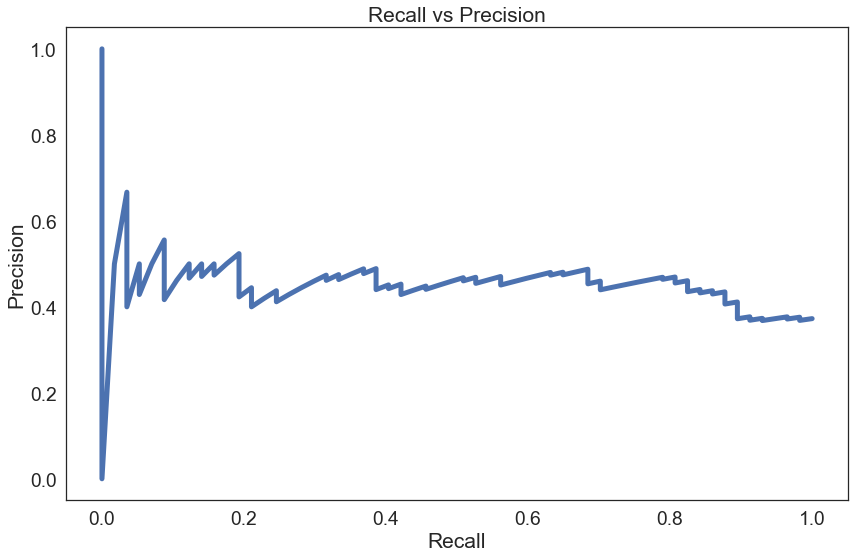

In [190]:
precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class, error_df.Reconstruction_error)
plt.plot(recall_rt, precision_rt, linewidth=5, label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

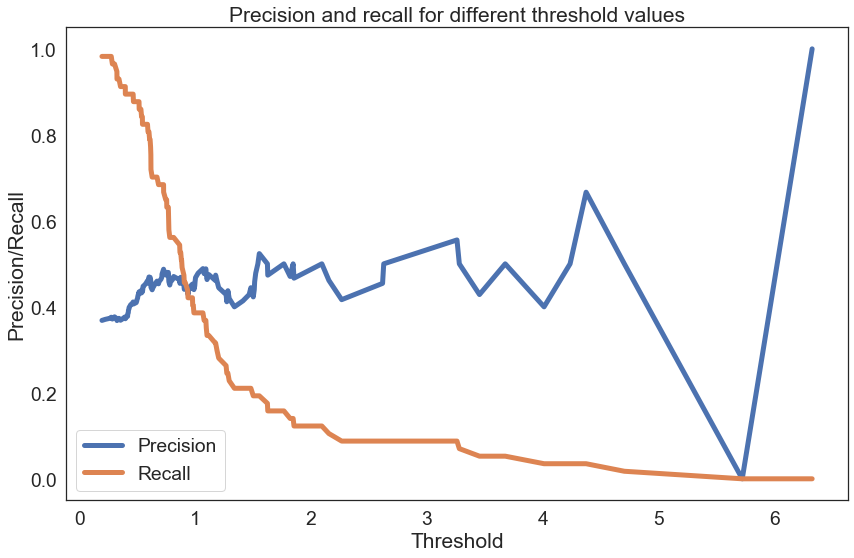

In [191]:
plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=5)
plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=5)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

## Adjusting the classification threshold to improve ROC curve

In [193]:
# instantiate model
logreg = LogisticRegression()

# fit model
logreg.fit(train_X, train_y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [194]:
# print the first 10 predicted responses
# 1D array (vector) of binary values (0, 1)
logreg.predict(test_X)[0:10]

array([0, 1, 1, 0, 0, 0, 0, 0, 1, 0], dtype=int64)

In [196]:
# print the first 10 predicted probabilities for class 1
logreg.predict_proba(test_X)[0:10, 1]

array([0.07151752, 0.86296744, 0.73226619, 0.14068737, 0.35171757,
       0.48834667, 0.07754658, 0.27309862, 0.94018214, 0.13372641])

In [197]:
# store the predicted probabilities for class 1
y_pred_prob = logreg.predict_proba(test_X)[:, 1]

In [198]:
# allow plots to appear in the notebook
%matplotlib inline

# adjust the font size 
plt.rcParams['font.size'] = 12

Text(0, 0.5, 'Frequency')

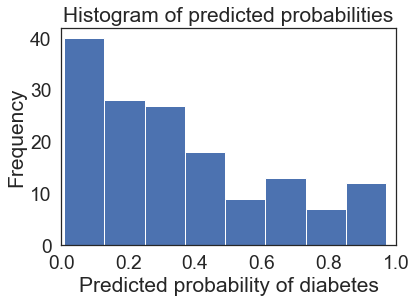

In [199]:
# histogram of predicted probabilities

# 8 bins
plt.hist(y_pred_prob, bins=8)

# x-axis limit from 0 to 1
plt.xlim(0,1)
plt.title('Histogram of predicted probabilities')
plt.xlabel('Predicted probability of diabetes')
plt.ylabel('Frequency')

The graph above shows the probabilities for the positive data (diabetes) to be predicted as 1 by the model. We can see from the first bar that many observations have probability of 0 to 0.1, Small number of observations with probability of greater than 0.5. This is below the threshold of 0.5 and most would be predicted "no diabetes" in this case. The solution is to decrease the threshold for predicting diabetes which results is increasing the sensitivity of the classifier.

In [210]:
y_pred = (logreg.predict_proba(test_X)[:,1] >= 0.3).astype(bool) # set threshold as 0.3

In [212]:
y_pred_prob[0:10]

array([0.07151752, 0.86296744, 0.73226619, 0.14068737, 0.35171757,
       0.48834667, 0.07754658, 0.27309862, 0.94018214, 0.13372641])

In [214]:
# print the first 10 predicted classes with the lower threshold
y_pred[0:10]

array([False,  True,  True, False,  True,  True, False, False,  True,
       False])

In [218]:
#Prediction accuracy with the lower threshold
print(metrics.accuracy_score(test_y, y_pred))

0.7402597402597403


In [219]:
# Confusion matrix with the lower threshold
print(metrics.confusion_matrix(test_y, y_pred))

[[69 28]
 [12 45]]


In [220]:
# save confusion matrix and slice into four pieces
confusion = metrics.confusion_matrix(test_y, y_pred)
print(confusion)
#[row, column]
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]

[[69 28]
 [12 45]]


In [222]:
# Double checking the calculations. use float to perform true division, not integer division
print((TP + TN) / float(TP + TN + FP + FN))
print(metrics.accuracy_score(test_y, y_pred))

0.7402597402597403
0.7402597402597403


In [223]:
# classification error with the lower threshold
classification_error = (FP + FN) / float(TP + TN + FP + FN)

print(classification_error)
print(1 - metrics.accuracy_score(test_y, y_pred))

0.2597402597402597
0.2597402597402597


In [224]:
# Sensitivity with the lower threshold
sensitivity = TP / float(FN + TP)

print(sensitivity)
print(metrics.recall_score(test_y, y_pred))

0.7894736842105263
0.7894736842105263


In [225]:
#Specifity with the lower threshold
specificity = TN / (TN + FP)
print(specificity)

0.711340206185567


In [226]:
false_positive_rate = FP / float(TN + FP)

print(false_positive_rate)
print(1 - specificity)

0.28865979381443296
0.28865979381443296


In [227]:
#Precision with the lower threshold
precision = TP / float(TP + FP)

print(precision)
print(metrics.precision_score(test_y, y_pred))

0.6164383561643836
0.6164383561643836


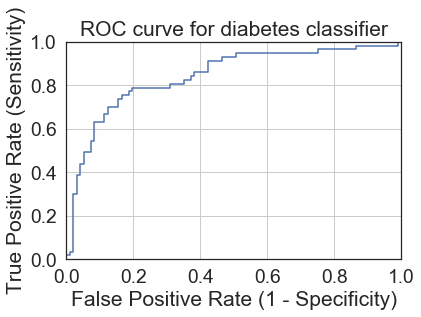

In [228]:
# Note: first argument is true values, second argument is predicted probabilities

# we pass y_test and y_pred_prob
# we do not use y_pred_class, because it will give incorrect results without generating an error
# roc_curve returns 3 objects fpr, tpr, thresholds
# fpr: false positive rate
# tpr: true positive rate
fpr, tpr, thresholds = metrics.roc_curve(test_y, y_pred_prob)

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for diabetes classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

In [229]:
# define a function that accepts a threshold and prints sensitivity and specificity
def evaluate_threshold(threshold):
    print('Sensitivity:', tpr[thresholds > threshold][-1])
    print('Specificity:', 1 - fpr[thresholds > threshold][-1])

In [231]:
evaluate_threshold(0.5)

Sensitivity: 0.543859649122807
Specificity: 0.9175257731958762


In [232]:
evaluate_threshold(0.3)

Sensitivity: 0.7894736842105263
Specificity: 0.8041237113402062


In [234]:
#auc score
print(metrics.roc_auc_score(test_y, y_pred_prob))

0.8426478567552904


We can see that adjusting threshold has significantly improved ROC curve and Sensitivity. Based on the project objectives, threshold can be changed to achive a higher Sensitivity or Specificity.

# Trying Feature Importance

In [135]:
# split into input (X) and output (Y) variables
X_selected = dataset.iloc[:,[0,1,5,7]]
y = dataset.iloc[:,8]

In [138]:
# Standardize the data before modeling  
sc = StandardScaler()
sc.fit(X_selected)
X_std_selected = sc.transform(X_selected)

In [140]:
#splitting train and test data
train_X_2, test_X_selected, train_y, test_y = train_test_split(X_std_selected,y,test_size=TEST_PCT , random_state=7)

In [141]:
#splitting train data into train and validation 
X_train_selected, X_valid_selected, y_train, y_valid = train_test_split(train_X_2,train_y,test_size=TEST_PCT , random_state=7)

In [143]:
#covert data to numpy array
X_2 = np.asarray(X_std_selected)
y_2 = np.asarray(y)

In [145]:
#cross validation using Stratified K fold
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
cvscores = []
for train, test in kfold.split(X_2, y_2):
  # create model
    model = Sequential()
    model.add(Dense(12, input_dim=4, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    # Fit the model
    final=model.fit(X_2[train], y_2[train], epochs=150, batch_size=10, verbose=0)
    # evaluate the model
    scores = model.evaluate(X_2[test], y_2[test], verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)
print("%.2f%% (+/- %.2f%%)" % (numpy.mean(cvscores), numpy.std(cvscores)))

accuracy: 76.62%
accuracy: 74.03%
accuracy: 80.52%
accuracy: 85.71%
accuracy: 71.43%
accuracy: 75.32%
accuracy: 80.52%
accuracy: 70.13%
accuracy: 77.63%
accuracy: 72.37%
76.43% (+/- 4.58%)


In [150]:
#Evaluate model on test data
print('test loss, test acc:',model.evaluate(test_X_selected,test_y,verbose=2))

test loss, test acc: [0.5551554436807509, 0.7662337422370911]


In [151]:
test_X_predictions = model.predict(test_X_selected)
mse = np.mean(np.power(test_X_selected - test_X_predictions, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': test_y})
#error_df.describe()
error_df.True_class.value_counts()

0    97
1    57
Name: True_class, dtype: int64

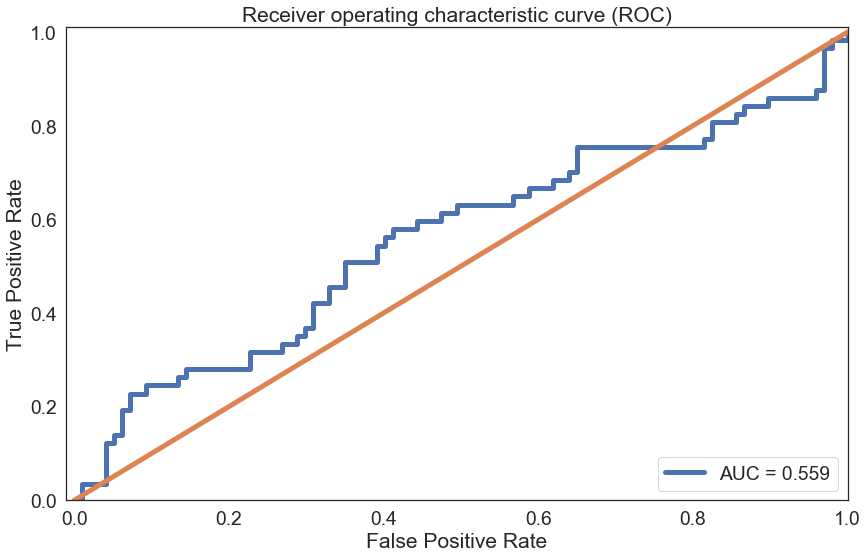

In [152]:
false_pos_rate, true_pos_rate, thresholds = roc_curve(error_df.True_class, error_df.Reconstruction_error)
roc_auc = auc(false_pos_rate, true_pos_rate,)

plt.plot(false_pos_rate, true_pos_rate, linewidth=5, label='AUC = %0.3f'% roc_auc)
plt.plot([0,1],[0,1], linewidth=5)

plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.legend(loc='lower right')
plt.title('Receiver operating characteristic curve (ROC)')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

We can see that using the features which have higher correlation with output did not improve our model. 

# Conclusions

1. Scaling had a great effect on improving the accuracy of neural network model.


2. Examining model's parameters and hyper parameters resulted in not only faster computation, but also a better control which helped to improve the accuaracy of model.


3. The default threshold resulted in a not satisfying ROC curve (low AUC). It was significantly improved by adjusting the threshold.


4. Developping a model using the 4 higher correlated features did not improve the model.


5. The best proposed model is as following with accuracy of 77.48% (+/- 3.51%):

    model.add(Dense(16, input_dim=8, kernel_regularizer=regularizers.l2(0.09), activation='selu'))
    
    model.add(Dense(8, activation='selu'))
    
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy', optimizer='AdaGrad', metrics=['accuracy'])
    
    model.fit(X[train], y[train], epochs=100, batch_size=64, verbose=0)
    